# Gathering Station Location Data

Indego provides an API to get current status data for each of the stations. This data contains some information I want such as the locations of each stations and the number of docks they have. This API can be accessed in the same location as the rest of the Indego data: https://www.rideindego.com/about/data/

Here I will also import neighborhood data for Philadelphia. I am using a shapefile of neighborhoods as defined by a city survey. This is available at: https://github.com/azavea/geo-data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import requests
pd.options.display.float_format = '{:.3f}'.format

/home/owen/bin/anaconda3/envs/geo_env/lib/python3.8/site-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  warnings.warn(


In [2]:
# request the data
r = requests.get ('http://www.rideindego.com/stations/json/')
content = pd.read_json(r.content)

In [18]:
content['features'][0]

{'geometry': {'coordinates': [-75.16374, 39.95378], 'type': 'Point'},
 'properties': {'id': 3004,
  'name': 'Municipal Services Building Plaza',
  'coordinates': [-75.16374, 39.95378],
  'totalDocks': 30,
  'docksAvailable': 15,
  'bikesAvailable': 14,
  'classicBikesAvailable': 14,
  'smartBikesAvailable': 0,
  'electricBikesAvailable': 0,
  'rewardBikesAvailable': 14,
  'rewardDocksAvailable': 15,
  'kioskStatus': 'FullService',
  'kioskPublicStatus': 'Active',
  'kioskConnectionStatus': 'Active',
  'kioskType': 1,
  'addressStreet': '1401 John F. Kennedy Blvd.',
  'addressCity': 'Philadelphia',
  'addressState': 'PA',
  'addressZipCode': '19102',
  'bikes': [{'dockNumber': 4,
    'isElectric': False,
    'isAvailable': True,
    'battery': None},
   {'dockNumber': 5,
    'isElectric': False,
    'isAvailable': True,
    'battery': None},
   {'dockNumber': 7,
    'isElectric': False,
    'isAvailable': True,
    'battery': None},
   {'dockNumber': 9,
    'isElectric': False,
    'isA

In [3]:
# put the shapefile into a geopands GeoDataFrame
gdf = gpd.GeoDataFrame.from_features(content['features'])
gdf = gdf.set_crs('EPSG:4326')

In [4]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 34 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   geometry                143 non-null    geometry
 1   id                      143 non-null    int64   
 2   name                    143 non-null    object  
 3   coordinates             143 non-null    object  
 4   totalDocks              143 non-null    int64   
 5   docksAvailable          143 non-null    int64   
 6   bikesAvailable          143 non-null    int64   
 7   classicBikesAvailable   143 non-null    int64   
 8   smartBikesAvailable     143 non-null    int64   
 9   electricBikesAvailable  143 non-null    int64   
 10  rewardBikesAvailable    143 non-null    int64   
 11  rewardDocksAvailable    143 non-null    int64   
 12  kioskStatus             143 non-null    object  
 13  kioskPublicStatus       143 non-null    object  
 14  kioskConnectionSta

In [10]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

In [12]:
statement = gdf[gdf['id'] == 3005]['bikes']

1    [{'dockNumber': 3, 'isElectric': False, 'isAva...
Name: bikes, dtype: object


In [4]:
# load the neighborhoods shapefile
shape = gpd.read_file(r'data/geometry/Neighborhoods_Philadelphia')
shape = shape.to_crs('EPSG:4326')

In [6]:
shape.total_bounds

array([-75.280266,  39.867004, -74.955763,  40.137992])

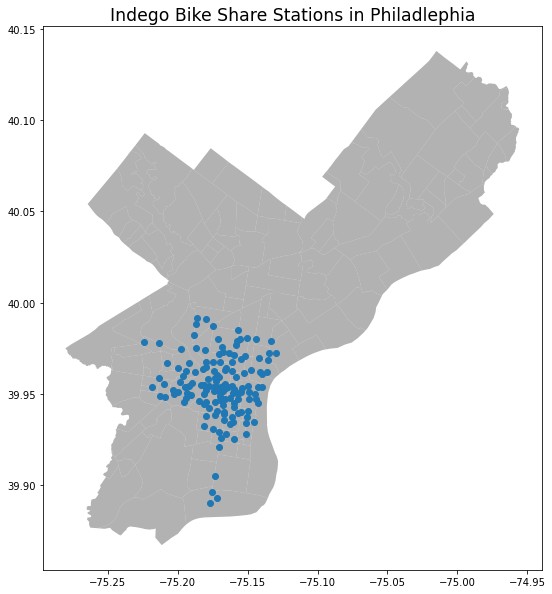

In [6]:
# Visualize location of stations withing the city
plt.figure(figsize=(10,10))
ax = plt.subplot(1,1,1)
shape.plot(ax=ax, alpha=.6, color='grey')
gdf.plot(ax=ax)
plt.title('Indego Bike Share Stations in Philadlephia', size='xx-large')
plt.savefig(r'images/Stations_in_Philadelphia.png')
plt.show()

In [7]:
# Create a new a frame with only neighborhoods that have a station

subset = []

for row in shape.iterrows():
    vals = []
    for point in gdf['geometry']:
        vals.append(row[1]['geometry'].contains(point))
    if any(vals):
        subset.append(row[1]['NAME'])

In [8]:
station_neighborhoods = shape[shape['NAME'].isin(subset)]

<AxesSubplot:>

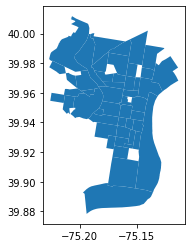

In [9]:
station_neighborhoods.plot()

In [10]:
# Save this frame to file
station_neighborhoods.to_file(r'data/geometry/station_neighborhoods')

In [ ]:
# I am only interested in a few of the columns
cols = ['geometry', 'id', 'coordinates', 'totalDocks']

In [11]:
# Trim the station columns down to only what I need
gdf = gdf[cols].copy()

In [ ]:
stations = pd.read_csv(r'data/indego/indego-stations.csv', names=['id', 'name', 'open_on', 'active'], header=0)

In [12]:
# Now add a neighborhood variable to the staion list
neighborhoods = []

for index, station in stations.iterrows():
    for i, neighborhood in shape.iterrows():
        if neighborhood['geometry'].contains(station['geometry']):
            neighborhoods.append(neighborhood['NAME'])
            
stations['neighborhood'] = neighborhoods

In [13]:
# Check to make sure it worked
stations.head()

,geometry,id,name,coordinates,totalDocks,latitude,longitude,neighborhood
0,POINT (-75.16374 39.95378),3004,Municipal Services Building Plaza,"[-75.16374, 39.95378]",30,39.954,-75.164,LOGAN_SQUARE
1,POINT (-75.14403 39.94733),3005,"Welcome Park, NPS","[-75.14403, 39.94733]",13,39.947,-75.144,OLD_CITY
2,POINT (-75.20311 39.95220),3006,40th & Spruce,"[-75.20311, 39.9522]",17,39.952,-75.203,UNIVERSITY_CITY
3,POINT (-75.15993 39.94517),3007,"11th & Pine, Kahn Park","[-75.15993, 39.94517]",20,39.945,-75.160,WASHINGTON_SQUARE
4,POINT (-75.15055 39.98078),3008,Temple University Station,"[-75.15055, 39.98078]",19,39.981,-75.151,HARTRANFT


In [14]:
# List typed column raises an error when saved to file
stations['coordinates'] = stations['coordinates'].apply(lambda x: str(x))

In [15]:
# Write the station information to file
stations.to_file(r'data/indego/indego_stations')

In [7]:
penn = gpd.read_file(r'data/geometry/pennsylvania.shp')

In [27]:
stations.total_bounds

NameError: name 'stations' is not defined

In [28]:
penn.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 9799 entries, 0 to 9798
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   osm_id      9799 non-null   object  
 1   code        9799 non-null   int64   
 2   fclass      9799 non-null   object  
 3   population  9799 non-null   int64   
 4   name        9787 non-null   object  
 5   geometry    9799 non-null   geometry
dtypes: geometry(1), int64(2), object(3)
memory usage: 459.5+ KB


In [24]:
import contextily as ctx